In [1]:
'''
Student Id : 21236158
Name       : Calvin Thomas Wynne
Model      : Linear Support Vector Machine with Soft Margin
'''

import os
import time
import random
import pickle
import numpy as np
import pandas as pd
import seaborn as sn
from datetime import datetime
import matplotlib.pyplot as plt


def prepare_data(df,  label_column, test_sample_ratio=0, columns_to_encode=[], columns_to_scale=[], 
                 columns_to_znorm=[], columns_to_drop=[]):
    
    '''
    Data that requires to be preprocessed or feature engineered is passed here. The function requires
    atleast 2 parameters, the input data in the form of a pandas dataframe and the name of the label
    attribute. Every other argument has been coded with a default value, and so might not require a
    value to be passed. 
    
    Parameters:
    ----------
    df : pandas.DataFrame()
        The input data that requires preprocessing is passed in as pandas dataframe with headers
        
    label_column : String.
        The name of the label column is passed in as a string. The string name passes must be exactly the
        same as the label column name
        
    test_sample_ratio : float value less than 1. Default : 0
        This value specifies the train test split ratio for the provided sample. If no value is provided
        the model would return the entired data in the form of a df as its output. If a valid ratio is
        provided, the function would return two dictionaries: training_set which has a key value pair of
        a class and its appropriate samples.
        
    columns_to_encode : List of Strings or a dictionary. Default value : []
        Names of columns that require one hot encoding, are passed in the form of a list of strings
        This allows for converting a column with categorical data into seperate individual columns of values 
        of 0 and 1. The orginal attribute that that is encoded, is dropped at the end of this operation.
        
    columns_to_scale : List of Strings
        Names of columns that require min-max scaling, are passed in the form of a list of strings
        This basically scales each attriutes by changing their value range. The resultant output is the
        range 0 to 1
        
    columns_to_znorm : List of Strings   
        Names of columns that require z normalization, are passed in the form of a list of strings
        A z-score describes the position of a raw score in terms of its distance from the mean, when 
        measured in standard deviation units. The z-score is positive if the value lies above the mean,
        and negative if it lies below the mean.
    
    columns_to_drop : List of Strings
        The list of columns that are to be dropped. These are columns which usually contributes little to 
        nothing to the model.
    
    
    Return:
    ------
    The Model would return two different types of outputs depeding on the input arguments
     -> if test_sample_ratio within the range of 0.01 to 0.99, the model would return :
          training_set : dictionary format: {class : list of attributes}
          test_set     : dictionary format: {class : list of attributes}
          dataframe    : pandas dataframe with the entire processed output format: pd.DataFrame()
     -> if the test_sample_ratio is 0 or left empty the model would return:
          dataframe    : pandas dataframe with the entire processed output format: pd.DataFrame()
          
    '''
    
    def z_normal(df, column):
        return df[column].apply(lambda value : (value - df[column].mean()) / df[column].std())
    
    def minmax_normal(df, column):
        return df[column].apply(lambda value : (value - df[column].min()) / (df[column].max() - df[column].min()))

    df = df.sample(frac = 1)
    for column in columns_to_scale:
        df[column] = minmax_normal(df, column)
        
    for column in columns_to_znorm:
        df[column] = z_normal(df, column)
    
    for col in columns_to_encode:
        for value_replace in columns_to_encode[col]:
            if isinstance(columns_to_encode[col], dict):
                new_colName = columns_to_encode[col][value_replace]
                df[new_colName] = df[col].apply(lambda x: 1 if x == value_replace else 0)   
            elif isinstance(columns_to_encode[col], list):
                df[value_replace] = df[col].apply(lambda x: 1 if x == value_replace else 0)
        df.drop(col, axis=1, inplace=True)
    
    for cols in columns_to_drop:
        df.drop(cols, axis=1, inplace=True)
        
    columns_df = list(df.columns)
    columns_df.remove(label_column)
    columns_df = [label_column] + columns_df
    df.columns = columns_df
    dataset = df.to_numpy()
    
    if test_sample_ratio > 0:
        
        if test_sample_ratio > 1:
            raise Exception("Test sample ratio greater than 1")
            
        test_size = test_sample_ratio
        training_set = {-1: [], 1:[]}
        test_set     = {-1: [], 1:[]}

        training_data = dataset[:-int(test_size * len(dataset)) ]
        test_data     = dataset[ -int(test_size * len(dataset)):]

        for record in training_data:
            training_set[record[0]].append(record[1:])

        for record in test_data:
            test_set[record[0]].append(record[1:]) 

        return training_set, test_set, df
    
    else :
        return df

In [3]:
class Custom_SVM:

    def __init__(self, verbose=False):
        '''
        Parameters:
        ----------
        Verbose : Boolean. Default: False
            This prints the certain logs during model execution. This is primarily used to test the model

        Return:
        ------
        None
        '''
        self.verbose = verbose
    
    def predict(self, attrs):
        classification = np.sign(np.dot(np.array(attrs), self.w) + self.b)
        return classification

    def accuracy(self, test_set):
        self.accurate_predictions, self.total_predictions = 0, 0
        for group in test_set:
            for data in test_set[group]:
                predicted_class = self.predict(data)
                if predicted_class == group:
                    self.accurate_predictions += 1
                self.total_predictions += 1
        self.accuracy = round(100 * (self.accurate_predictions/self.total_predictions), 3)
        print("Acurracy      :",str(self.accuracy))
    
    
    def calculate_f1(self, test_set, plot_graph=False):
        '''
        Calculate an evaluation score other than accuracy for a given set of predictions and labels.

        Args:
        labels (list): A list containing gold standard labels annotated as `0` and `1`.
        predictions (list): A list containing predictions annotated as `0` and `1`.

        Returns:
        float: A floating point value to score the predictions against the labels.
        '''
        
        TP, FP, TN, FN = 0, 0, 0, 0
        
        labels, predictions = [], []
        for group in test_set:
            for data in test_set[group]:
                predicted_class = self.predict(data)
                labels.append(int(group))
                predictions.append(int(predicted_class))
                    
        for actual_, predict_ in zip(labels, predictions):
            if actual_ != predict_:
                if actual_ == -1 and predict_ == 1:
                    FP += 1
                elif actual_ == 1 and predict_ == -1:
                    FN += 1
            else:
                if actual_ == 1:
                    TP += 1
                elif actual_ == -1:
                    TN += 1
        
        self.recall    = TP / (TP + FN)
        self.precision = TP / (TP + FP)
        self.f1_score  = 2  / ((1/self.recall) + (1/self.precision))
        self.recall    = round(self.recall * 100, 3)
        self.precision = round(self.precision * 100, 3)
        self.f1_score  = round(self.f1_score * 100, 3)

        if plot_graph:
            plot_data = {"Columns"  : ['Positive', 'Negative'],
                         "Positive" : [TP, FN],
                         "Negative" : [FP, TN]}
            tf = pd.DataFrame(plot_data, columns=["Columns", "Positive", "Negative"])
            tf = tf.set_index("Columns")
            plt.figure(figsize = (5,5))
            heatmap = sn.heatmap(tf, annot=True, linewidths=2, cmap="Set2", 
                                 annot_kws={"size": 16}, fmt='g', cbar=False)
            plt.xlabel("Actual Values") 
            plt.ylabel("Predicted Values") 
            
        print("f1 Score      :",str(self.f1_score))
        print("Precision     :",str(self.precision))
        print("Recall        :",str(self.recall))
        
    
    def create_transMatrix(self, num_features):
        matrix = []
        for i in range(2**num_features):
            b = bin(i)[2:]
            b = (str(0) * (num_features - len(b)) + b)
            out = [1 if val == "1" else -1 for val in b]
            matrix.append(out)
        return matrix
    
    
    def cost_function(self, norms):
        loss_dict, ret_dict  = {}, {}
        losses, dis_w  = [], []
        for supp_vector in norms:
            w, b = norms[supp_vector]
            loss = 0
            for each_sample in self.dataset[-1]:
                classification = np.sign(np.dot(each_sample, w) + b)
                if classification != -1:
                    loss += 1
            for each_sample in self.dataset[1]:
                classification = np.sign(np.dot(each_sample, w) + b)
                if classification != 1:
                    loss += 1           
            loss_dict[loss] = (w, b) 
            losses.append(loss)
            dis_w.append(supp_vector)
            
        for val1, val2, in zip(losses, dis_w):
            if max(losses) != min(losses):
                normalized_loss =   (val1 - min(losses)) / (max(losses) - min(losses)) 
            else:
                normalized_loss =   val1 / max(losses) 
            normalized_wp   =   (val2 - min(dis_w))  / (max(dis_w)  - min(dis_w))
            loss_param = normalized_loss + (self.alpha * normalized_wp)
            ret_dict[loss_param] = loss_dict[val1]
        lowest_loss = sorted([n for n in ret_dict])
        support_vector = ret_dict[lowest_loss[0]]
        if self.verbose:
            print("\n", lowest_loss[0], support_vector[0][0], support_vector[1])
        return support_vector
        
        
        
    def fit(self, dataset, alpha=1, b_range_multiple=5, b_multiple=5, slack_step=0.05):
        
        start_time = time.time()
        self.alpha, self.dataset = alpha, dataset
        
        self.num_features = len(list(dataset.items())[0][1][0])
        self.num_samples  = {-1:len(list(train_set[-1])), 1:len(list(train_set[1]))} 
        self.total_sample = self.num_samples[-1] + self.num_samples[1]

        transformations = self.create_transMatrix(self.num_features)
        self.transformations = transformations
    
        opt_dict, all_feature_values = {}, []
        
        for yi, attrs in self.dataset.items():
            for attr in attrs:
                for f in attr:
                    all_feature_values.append(f)
        
        self.max_attr, self.min_attr = max(all_feature_values), min(all_feature_values)
        del all_feature_values
        
        
        latest_optimum = self.max_attr * 10
        step_sizes = [self.max_attr * 0.1, self.max_attr * 0.05] 
        for step in step_sizes:
            slack = 0
            w = np.array([latest_optimum for _ in range(self.num_features)])
            optimized = False
            while not optimized:
                found_params = (None, None)
                for b in np.arange(-1*(self.max_attr * b_range_multiple),
                                   self.max_attr * b_range_multiple,
                                   step * b_multiple):
                    
                    for transformation in transformations:
                        w_t = w * transformation
                        failed_constraint = 0
                        for label_class in self.dataset:
                            len_cur = len(self.dataset[label_class])
                            
                            for xi in self.dataset[label_class]:
                                if failed_constraint/len_cur > slack:
                                    break
                                yi = label_class
                                if not yi * (np.dot(xi, w_t) + b) >= 1 :
                                    failed_constraint += 1 
                        
                        if failed_constraint/len_cur <= slack:
                            opt_dict[np.linalg.norm(w_t)] = [w_t,b]

                if w[0] < 0 :
                    if len(opt_dict) < 5 and slack <= 0.5:
                        w = np.array([latest_optimum for _ in range(self.num_features)])
                        slack += slack_step
                        
                        if self.verbose:
                            print("\n")
                            print("Num Support Vectors : ", len(opt_dict))
                            print("Increasing Slack to : ", slack * 100, "%")
                    else:
                        optimized = True
                        if self.verbose:
                            print("\n")
                            print("Num Support Vectors : ", len(opt_dict))
                            print('Optimized a step.')
                else:
                    w = w - step
                    
            self.w, self.b = self.cost_function(opt_dict)
            latest_optimum = self.w[0] + step * 2   
        self.training_time = round(time.time() - start_time, 2)
        print("\n\nTraining time :", self.training_time)
    
    
    
    def load_model(self, file_name=None):
        if self.verbose:
            print("Loading model from a Checkpoint file")
        if file_name == None:
            if os.path.isfile(os.path.abspath(os.path.join(os.getcwd(), 'Checkpoints.pickle'))):
                if self.verbose:
                    print("Found a Checkpoint file")
                with open(os.path.abspath(os.path.join(os.getcwd(), 'Checkpoints.pickle')), 'rb') as f:
                    self.bin = pickle.load(f)
            else:
                print("No Checkpoint found")
                self.bin = {}
        else:
            if os.path.isfile(os.path.abspath(file_name)):
                with open(os.path.abspath(file_name), 'rb') as f:
                    self.bin = pickle.load(f)
            else:
                raise Exception("Save file doesnot exist")
        
        if len(self.bin.keys()) != 0 and self.verbose:
            latest_checkpoint = sorted(list(self.bin.keys()), reverse=True)[0]
            self.w = self.bin[latest_checkpoint]['w']
            self.b = self.bin[latest_checkpoint]['b']
            self.accuracy = self.bin[latest_checkpoint]["acc"]
            self.training_time = self.bin[latest_checkpoint]["time"]
            print("Model successfully loaded\n")
            print("Loaded Model :", latest_checkpoint)
            print("W value      :", self.w[0])
            print("b value      :", self.b)
            print("Accuracy     :", self.accuracy)
            print("f1 Score     :", self.f1_score)
        

    def save_model(self, file_name=None):
        if file_name == None:
            file_name = os.path.abspath(os.path.join(os.getcwd(), 'Checkpoints.pickle'))
        else:
            file_name = os.path.abspath(file_name)
        model_name = int(datetime.now().strftime("%Y%m%d%H%M%S"))
        bin_cur = {
            model_name : {
                "w"   : self.w,
                "b"   : self.b,
                "acc" : self.accuracy,
                "f1"  : self.f1_score,
                "time": self.training_time
            }
        }
        self.load_model()
        self.bin.update(bin_cur)
        
        self.w = bin_cur[model_name]["w"]
        self.b = bin_cur[model_name]["b"]
        self.accuracy = bin_cur[model_name]["acc"]
        self.f1_score = bin_cur[model_name]["f1"]
        self.training_time = bin_cur[model_name]["time"]
        
        with open(file_name, 'wb') as f:
            pickle.dump(self.bin, f, protocol=pickle.HIGHEST_PROTOCOL)
        print("Model saved!\n")
            
            
    def show_checkPoints(self):
        if len(self.bin) == 0:
            self.load_model()
        
        print("\nAvailable Checkpoints")
        for param in self.bin:
            print("\nModel number :", param)
            print("W value      :", self.bin[param]['w'][0])
            print("b value      :", self.bin[param]['b'])
            print("Accuracy     :", self.bin[param]["acc"])
            print("f1 Score     :", self.bin[param]["f1"])
            print("Training time:", self.bin[param]["time"])
            



Training time : 13.02
Acurracy      : 68.657
f1 Score      : 77.419
Precision     : 63.158
Recall        : 100.0
Model saved!

Accuracy SKlearn: 89.78102189781022


Training time : 13.06
Acurracy      : 56.716
f1 Score      : 67.416
Precision     : 50.847
Recall        : 100.0
Model saved!

Accuracy SKlearn: 85.40145985401459


Training time : 55.63
Acurracy      : 82.09
f1 Score      : 86.364
Precision     : 79.167
Recall        : 95.0
Model saved!

Accuracy SKlearn: 86.86131386861314


Training time : 13.03
Acurracy      : 64.179
f1 Score      : 73.333
Precision     : 57.895
Recall        : 100.0
Model saved!

Accuracy SKlearn: 87.59124087591242


Training time : 14.21
Acurracy      : 59.701
f1 Score      : 69.663
Precision     : 53.448
Recall        : 100.0
Model saved!

Accuracy SKlearn: 91.97080291970804


Training time : 11.99
Acurracy      : 65.672
f1 Score      : 75.789
Precision     : 61.017
Recall        : 100.0
Model saved!

Accuracy SKlearn: 88.32116788321169


Training t

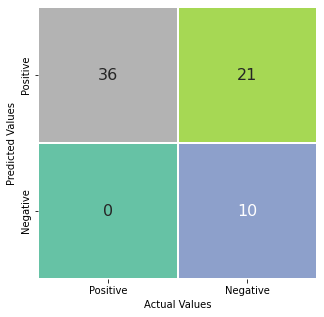

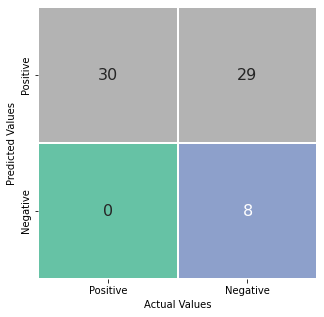

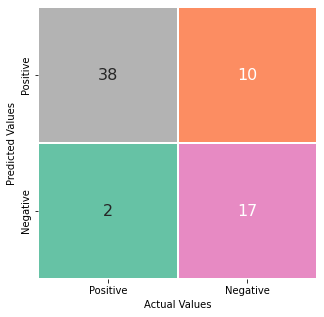

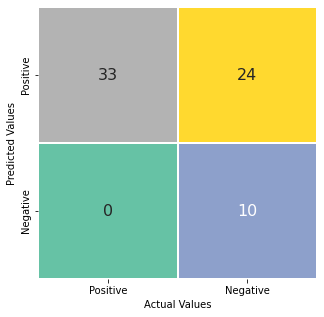

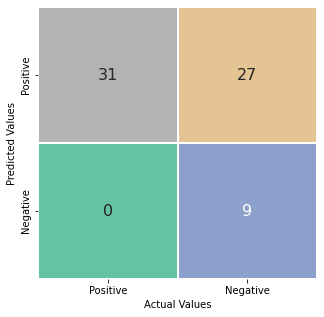

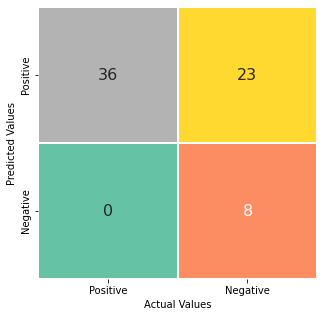

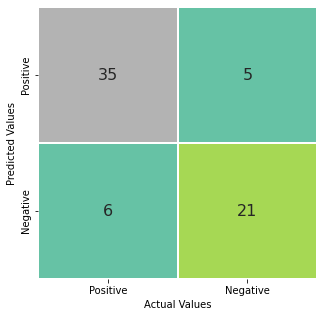

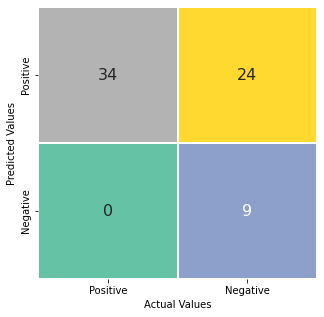

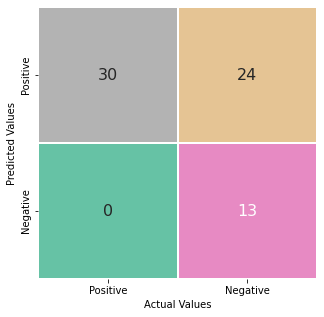

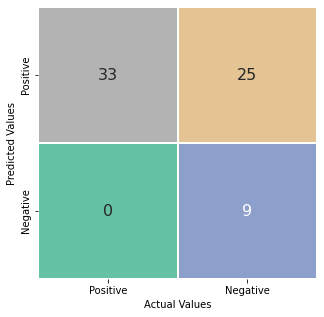

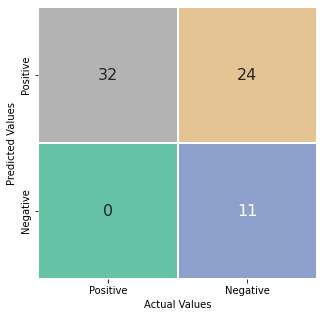

In [15]:
'''
This block of code runs both models and shows the output
'''


from sklearn import svm
from sklearn import metrics


accuracy_dict = {}

for itr in range(11):
    
    dataset = pd.read_csv("wildfires.txt", sep="\t")

    cols_to_scale  = ['temp', 'humidity', "rainfall", "drought_code", "buildup_index", "wind_speed"]
    cols_to_znorm  = ["rainfall", "drought_code", "buildup_index", "wind_speed"]
    cols_to_encode = {"month" : {6:'jun', 7:'jul', 8:'aug', 9:'sep'}}
    cols_to_encode = []
    cols_to_drop   = ["day", "year", "month"]

    dataset["yes"] = dataset["yes"].apply(lambda row: -1 if "no" in row else 1)

    train_set, test_set, df = prepare_data(dataset, "yes",  0.33, cols_to_encode, cols_to_scale, cols_to_znorm, cols_to_drop)

    customSvm = Custom_SVM(verbose=False)
    customSvm.fit(train_set)
    customSvm.accuracy(test_set)
    customSvm.calculate_f1(test_set, True)
    customSvm.save_model()
    
    sample_size = int(0.33 * df.shape[0])
    X_train , y_train = df.iloc[:sample_size][df.columns[1:]], df.iloc[:sample_size]["yes"]
    X_test, y_test = df.iloc[:df.shape[0] - sample_size][df.columns[1:]], df.iloc[: df.shape[0] - sample_size]["yes"]

    clf = svm.SVC(kernel='linear') 
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy SKlearn:", metrics.accuracy_score(y_test, y_pred) * 100)
    
    accuracy_dict.update({itr+1 : (customSvm.accuracy , metrics.accuracy_score(y_test, y_pred) * 100, 
                                   customSvm.f1_score , metrics.f1_score(y_test, y_pred) * 100)})
    

<AxesSubplot:>

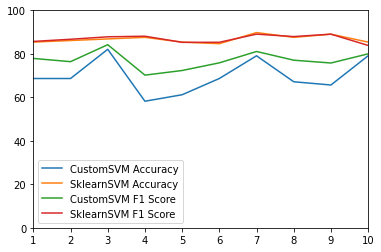

In [11]:
acc_df  = pd.DataFrame.from_dict(accuracy_dict).transpose()
acc_df.columns = ['CustomSVM Accuracy', 'SklearnSVM Accuracy', 'CustomSVM F1 Score', 'SklearnSVM F1 Score']
acc_df.plot(ylim=(0,100), xlim=(1, 10))

<AxesSubplot:>

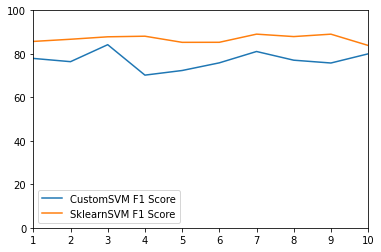

In [12]:
acc_df[['CustomSVM F1 Score', 'SklearnSVM F1 Score']].plot(ylim=(0,100), xlim=(1, 10))

In [13]:
acc_df

,CustomSVM Accuracy,SklearnSVM Accuracy,CustomSVM F1 Score,SklearnSVM F1 Score
1,68.657,85.401460,77.895,85.714286
2,68.657,86.131387,76.404,86.713287
3,82.090,86.861314,84.211,87.837838
4,58.209,87.591241,70.213,88.111888
5,61.194,85.401460,72.340,85.294118
6,68.657,84.671533,75.862,85.314685
7,79.104,89.781022,81.081,89.062500
8,67.164,87.591241,77.083,87.943262
9,65.672,89.051095,75.789,89.051095
10,79.104,85.401460,80.000,83.870968
